In [55]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import requests
from pattern import web
import re, string
from sets import Set
from collections import Counter
from fuzzywuzzy import fuzz

pd.set_option('display.max_rows', 5)

database = {}

#uh-oh

# TOP secondary tpyes
# ratings
# set
# rarity

# pca analysis
# automated feature selection
# k-means clustering

# predictors of popularity

In [206]:
# Global vars

cardCount = 4972

textFeatures = True
functionalFeatures = True
keywordFeatures = True

In [57]:
# Silly helper functions

def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def anyIntOrColor(l):
    for val in l:
        if isInt(val) | (val in ['Black', 'Red', 'Green', 'Blue', 'White']) : return True
    return False

# Scrape baby, scrape

In [58]:
# scrapes:

# name, types, text (lowered, alphanumeritized), mana cost,
# cmc, power and toughness,

# and adds it to the global card database

def grabCard(multiverse_id):
    xml = "http://gatherer.wizards.com/Pages/Card/Details.aspx?multiverseid=" + str(multiverse_id)
    dom = web.Element(requests.get(xml).text)
    
    # card name, card type
    
    cardName = dom('div.cardImage img')[0].attributes['alt'] if dom('div .cardImage img') else ''
        
    cardType = [element.strip() for element in \
                dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_typeRow div.value')[0].content.split(u'\u2014')]
    
    # extract, parse, clean text into a list
    
    cardText = []
    pattern = re.compile('[\W_]+')
    for line in dom('div.cardtextbox'):
        for element in line:
            cardText.append(element)
    
    for i in xrange(len(cardText)):
        if cardText[i].type == 'element' and cardText[i].tag == 'img':
            cardText[i] = cardText[i].attributes['alt']
        else:
            cardText[i] = str(cardText[i]).strip().lower()
        pattern.sub('', cardText[i]) 
    
    # mana symbols
    
    manaCost = [element.attributes['alt'] for element in dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_manaRow div.value img')]
    cmc = int(dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_cmcRow div.value')[0].content.strip()) \
            if dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_cmcRow div.value') else np.nan
    
    # p/t
    
    power = np.nan
        
    power = [_.strip() for _ in dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_ptRow div.value')[0].content.split(' / ')][0] \
                if dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_ptRow div.value') else np.nan
    power = float(power) if power != '*' and power != np.nan else np.nan
    
    toughness = [_.strip() for _ in dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_ptRow div.value')[0].content.split(' / ')][1] \
                    if dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_ptRow div.value') else np.nan
    toughness = float(toughness) if (toughness != '*' and toughness != '7-*' and toughness != np.nan) else np.nan
      
    # add data
    
    database[cardName] = {
                            'cardType' : cardType,
                            'cardText' : cardText,
                            'manaCost' : manaCost,
                            'cmc' : cmc,
                            'power' : power,
                            'toughness' : toughness
                         }
    

In [59]:
def combineVersions(multiverse_id):
    return

In [73]:
for i in xrange(1, 500):
    print i
    grabCard(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [143]:
database['Black Lotus']

{'cardText': [u'Tap',
  ', sacrifice black lotus: add three mana of any one color to your mana pool.'],
 'cardType': [u'Artifact'],
 'cmc': 0,
 'manaCost': [u'0'],
 'power': nan,
 'toughness': nan}

# Process scrapage

In [244]:
data = pd.DataFrame.from_dict(database, orient='index')
data['cardName'] = data.index
data

,toughness,power,cmc,cardType,cardText,manaCost,cardName
Air Elemental,4,4,5,"[Creature, Elemental]",[flying],"[3, Blue, Blue]",Air Elemental
Ancestral Recall,NaN,NaN,1,[Instant],[target player draws three cards.],[Blue],Ancestral Recall
Animate Artifact,NaN,NaN,4,"[Enchantment, Aura]","[enchant artifact, as long as enchanted artifa...","[3, Blue]",Animate Artifact
Animate Dead,NaN,NaN,2,"[Enchantment, Aura]","[enchant creature card in a graveyard, when an...","[1, Black]",Animate Dead
Animate Wall,NaN,NaN,1,"[Enchantment, Aura]","[enchant wall, enchanted wall can attack as th...",[White],Animate Wall
Ankh of Mishra,NaN,NaN,2,[Artifact],"[whenever a land enters the battlefield, ankh ...",[2],Ankh of Mishra
Armageddon,NaN,NaN,4,[Sorcery],[destroy all lands.],"[3, White]",Armageddon
Aspect of Wolf,NaN,NaN,2,"[Enchantment, Aura]","[enchant creature, enchanted creature gets +x/...","[1, Green]",Aspect of Wolf
Bad Moon,NaN,NaN,2,[Enchantment],[black creatures get +1/+1.],"[1, Black]",Bad Moon
Badlands,NaN,NaN,NaN,"[Land, Swamp Mountain]","[<i>(<img src=""/handlers/image.ashx?size=small...",[],Badlands


In [256]:
# derive mana features

# card colors

colorlessMana = []
colorless = []

for row in data['manaCost']:
    found = 0
    for val in row:
        if isInt(val):
            colorlessMana.append(float(val))
            found = 1
    if found == 0:
        colorlessMana.append(0)

data['colorlessMana'] = colorlessMana 
data['Variable Colorless'] = [1 if 'Variable Colorless' in text else 0 for text in data['manaCost']]

# count mana symbols

manaSymbols = []

manaSymbols = ['Blue', 'Black', 'Red', 'Green', 'White']
manaVars = ['mana_' + _ for _ in manaSymbols]

for i in xrange(len(manaSymbols)):
    data[manaVars[i]] = [text.count(manaSymbols[i]) for text in data['manaCost']]
    data[manaSymbols[i]] = [1 if text.count(manaSymbols[i]) > 0 else 0 for text in data['manaCost']]

# find color (ignores multicolor)

def isColorless(l):
    for val in l:
        if val in manaSymbols: return False
    return True

data['Artifact'] = [1 if isColorless(x) else 0 for x in data['manaCost']]

def findColor(l):
    for val in l:
        if not isInt(val) and val != 'Variable Colorless': return val
    return 'Artifact'

data['color'] = [findColor(l) for l in data['manaCost']]

data.groupby(data['color']).describe().to_csv('colorSummary.csv')
data.groupby(data['color']).describe()

toughness      power        cmc  colorlessMana  \
color                                                            
Artifact count   5.000000   5.000000  47.000000      61.000000   
         mean    5.000000   2.400000   2.361702       1.819672   
         std     1.414214   2.302173   1.673652       1.774901   
         min     3.000000   0.000000   0.000000       0.000000   
         25%     4.000000   0.000000   1.000000       0.000000   
         50%     6.000000   3.000000   2.000000       1.000000   
         75%     6.000000   4.000000   4.000000       4.000000   
         max     6.000000   5.000000   6.000000       6.000000   
Black    count  16.000000  16.000000  46.000000      46.000000   
         mean    2.500000   2.125000   2.543478       1.043478   
         std     1.751190   1.857418   1.456122       1.246444   
         min     1.000000   0.000000   1.000000       0.000000   
...                   ...        ...        ...            ...   
Red      25%     2.000000   1.000000   1.000000       0.000000   
         50%     3.000000   2.000000   3.000000       1.000000   
         75%     4.000000   3.000000   3.750000       2.000000   
         max     8.000000   5.000000   6.000000       4.000000   
White    count  11.000000  11.000000  45.000000      45.000000   
         mean    2.818182   2.454545   2.222222       0.888889   
         std     1.887760   1.507557   1.396243       1.091751   
         min     1.000000   1.000000   1.000000       0.000000   
         25%     1.000000   1.500000   1.000000       0.000000   
         50%     2.000000   2.000000   2.000000       0.000000   
         75%     4.500000   3.000000   3.000000       2.000000   
         max     6.000000   6.000000   6.000000       3.000000   

                Variable Colorless  mana_Blue  Blue  mana_Black  Black  \
color                                                                    
Artifact count           61.000000         61    61   61.000000     61   
         mean             0.000000          0     0    0.000000      0   
         std              0.000000          0     0    0.000000      0   
         min              0.000000          0     0    0.000000      0   
         25%              0.000000          0     0    0.000000      0   
         50%              0.000000          0     0    0.000000      0   
         75%              0.000000          0     0    0.000000      0   
         max              0.000000          0     0    0.000000      0   
Black    count           46.000000         46    46   46.000000     46   
         mean             0.065217          0     0    1.500000      1   
         std              0.249637          0     0    0.722649      0   
         min              0.000000          0     0    1.000000      1   
...                            ...        ...   ...         ...    ...   
Red      25%              0.000000          0     0    0.000000      0   
         50%              0.000000          0     0    0.000000      0   
         75%              0.000000          0     0    0.000000      0   
         max              1.000000          0     0    0.000000      0   
White    count           45.000000         45    45   45.000000     45   
         mean             0.022222          0     0    0.000000      0   
         std              0.149071          0     0    0.000000      0   
         min              0.000000          0     0    0.000000      0   
         25%              0.000000          0     0    0.000000      0   
         50%              0.000000          0     0    0.000000      0   
         75%              0.000000          0     0    0.000000      0   
         max              1.000000          0     0    0.000000      0   

                mana_Red    ...          haste  hexproof  indestructible  \
color                       ...                                            
Artifact count        61    ...      61.000000        61              61   
      

In [246]:
# type features

data['Primary Type'] = [cardType[0] for cardType in data['cardType']]
data = pd.concat([data, pd.get_dummies(data['Primary Type'])], axis=1)

data.groupby(data['Primary Type']).describe().to_csv('typeSummaries.csv')
data.groupby(data['Primary Type']).describe()

toughness     power        cmc  colorlessMana  \
Primary Type                                                             
Artifact          count       1.00  1.000000  43.000000      43.000000   
                  mean        6.00  3.000000   2.116279       2.116279   
                  std          NaN       NaN   1.499354       1.499354   
                  min         6.00  3.000000   0.000000       0.000000   
                  25%         6.00  3.000000   1.000000       1.000000   
                  50%         6.00  3.000000   2.000000       2.000000   
                  75%         6.00  3.000000   4.000000       4.000000   
                  max         6.00  3.000000   5.000000       5.000000   
Artifact Creature count       4.00  4.000000   4.000000       4.000000   
                  mean        4.75  2.250000   5.000000       5.000000   
                  std         1.50  2.629956   1.154701       1.154701   
                  min         3.00  0.000000   4.000000       4.000000   
...                            ...       ...        ...            ...   
Land              25%          NaN       NaN        NaN       0.000000   
                  50%          NaN       NaN        NaN       0.000000   
                  75%          NaN       NaN        NaN       0.000000   
                  max          NaN       NaN        NaN       0.000000   
Sorcery           count       0.00  0.000000  30.000000      30.000000   
                  mean         NaN       NaN   2.333333       0.966667   
                  std          NaN       NaN   1.061337       1.066200   
                  min          NaN       NaN   1.000000       0.000000   
                  25%          NaN       NaN   1.250000       0.000000   
                  50%          NaN       NaN   2.000000       1.000000   
                  75%          NaN       NaN   3.000000       2.000000   
                  max          NaN       NaN   4.000000       3.000000   

                         Variable Colorless  mana_Blue       Blue  mana_Black  \
Primary Type                                                                    
Artifact          count           43.000000  43.000000  43.000000   43.000000   
                  mean             0.000000   0.000000   0.000000    0.000000   
                  std              0.000000   0.000000   0.000000    0.000000   
                  min              0.000000   0.000000   0.000000    0.000000   
                  25%              0.000000   0.000000   0.000000    0.000000   
                  50%              0.000000   0.000000   0.000000    0.000000   
                  75%              0.000000   0.000000   0.000000    0.000000   
                  max              0.000000   0.000000   0.000000    0.000000   
Artifact Creature count            4.000000   4.000000   4.000000    4.000000   
                  mean             0.000000   0.000000   0.000000    0.000000   
                  std              0.000000   0.000000   0.000000    0.000000   
                  min              0.000000   0.000000   0.000000    0.000000   
...                                     ...        ...        ...         ...   
Land              25%              0.000000   0.000000   0.000000    0.000000   
                  50%              0.000000   0.000000   0.000000    0.000000   
                  75%              0.000000   0.000000   0.000000    0.000000   
                  max              0.000000   0.000000   0.000000    0.000000   
Sorcery           count           30.000000  30.000000  30.000000   30.000000   
                  mean             0.300000   0.300000   0.166667    0.400000   
                  std              0.466092   0.749713   0.379049    0.770132   
                  min              0.000000   0.000000   0.000000    0.000000   
                  25%              0.000000   0.000000   0.000000    0.000000   
                  50%              0.000000   0.000000   0.000000    0.000000   
 

# Feature extraction

In [247]:
def partialMatch(s, l, threshold=95):
    fuzzVals = [fuzz.partial_ratio(s, x) for x in l]
    if not fuzzVals: fuzzVals = [0]
    return max(fuzzVals) >= threshold

In [248]:
# derive card text-derived features

if textFeatures:

    data['Damage'] = [1 if partialMatch('damage', l) else 0 for l in data['cardText']]
    data['Hand'] = [1 if partialMatch('hand', l) else 0 for l in data['cardText']]
    data['Draw'] = [1 if partialMatch('draw', l, 80) else 0 for l in data['cardText']]
    data['Upkeep'] = [1 if partialMatch('draw', l, 80) else 0 for l in data['cardText']]
    data['Library'] = [1 if partialMatch('library', l) else 0 for l in data['cardText']]
    data['Sacrifice'] = [1 if partialMatch('sacrifice', l) else 0 for l in data['cardText']]
    data['Destroy'] = [1 if partialMatch('destroy', l) else 0 for l in data['cardText']]
    data['Discard'] = [1 if partialMatch('discard', l) else 0 for l in data['cardText']]
    data['Prevent'] = [1 if partialMatch('prevent', l) else 0 for l in data['cardText']]
    data['Life'] = [1 if partialMatch('life', l) else 0 for l in data['cardText']]
    data['Attack'] = [1 if partialMatch('attack', l) else 0 for l in data['cardText']]
    data['Block'] = [1 if partialMatch('block', l) else 0 for l in data['cardText']]
    data['Search'] = [1 if partialMatch('search', l) else 0 for l in data['cardText']]
    data['Choose'] = [1 if partialMatch('choose', l) else 0 for l in data['cardText']]
    data['Copy'] = [1 if partialMatch('copy', l) else 0 for l in data['cardText']]
    data['Change'] = [1 if partialMatch('change', l) else 0 for l in data['cardText']]
    data['Turn'] = [1 if partialMatch('turn', l) else 0 for l in data['cardText']]
    data['End of turn'] = [1 if partialMatch('end of turn', l, 80) else 0 for l in data['cardText']]
    data['Beginning of turn'] = [1 if partialMatch('beginning of turn', l, 80) else 0 for l in data['cardText']]
    data['Spell ref'] = [1 if partialMatch('spell', l) else 0 for l in data['cardText']]
    data['Creature ref'] = [1 if partialMatch('creature', l) else 0 for l in data['cardText']]
    data['Land'] = [1 if partialMatch('land', l) else 0 for l in data['cardText']]
    data['Mana'] = [1 if partialMatch('mana', l) else 0 for l in data['cardText']]
    data['Battlefield'] = [1 if partialMatch('battlefield', l) else 0 for l in data['cardText']]

    data['Blue ref'] = [1 if partialMatch('blue', l) else 0 for l in data['cardText']]
    data['Black ref'] = [1 if partialMatch('black', l) else 0 for l in data['cardText']]
    data['Green ref'] = [1 if partialMatch('green', l) else 0 for l in data['cardText']]
    data['Red ref'] = [1 if partialMatch('red', l) else 0 for l in data['cardText']]
    data['White ref'] = [1 if partialMatch('white', l) else 0 for l in data['cardText']]
    data['Colorless ref'] = [1 if partialMatch('colorless', l) else 0 for l in data['cardText']]
    
    data.describe()

In [249]:
# functional features

def isBuff(str, l):
    found = 0
    for val in l:
        if str in val:
            found += 1
    if found > 0: return True
    else: return False

if functionalFeatures:

    data['Untap'] = [1 if partialMatch('untap', l) else 0 for l in data['cardText']]
    data['All'] = [1 if partialMatch('all', l) | partialMatch('any', l) else 0 for l in data['cardText']]

    data['Tap ability'] = [1 if 'Tap' in x else 0 for x in data['cardText']]
    data['Mana symbol'] = [1 if anyIntOrColor(x) else 0 for x in data['cardText']]
    data['Mana related'] = [1 if partialMatch('add mana', l) | partialMatch('your mana pool', l) \
                                  else 0 for l in data['cardText']]

    data['Buff'] = [1 if isBuff('+', l) else 0 for l in data['cardText']]
    data['Debuff'] = [1 if isBuff('-', l) else 0 for l in data['cardText']]

In [250]:
# keyword features

if keywordFeatures:

    creatureAbilities = ['deathtouch', 'defender', 'first strike', 'double strike', 'enchant', 'equip', \
     'flash', 'flying', 'haste', 'hexproof', 'indestructible', 'intimidate', 'lifelink', 'protection', 'reach', \
     'shroud', 'trample', 'vigilance']

    for ability in creatureAbilities:
        data[ability] = [1 if ability in text else 0 for text in data['cardText']]

In [367]:
# from matplotlib.colors import ColorConverter

# blue = ColorConverter.to_rgb['blue']
# green = ColorConverter.to_rgb['green']
# black = ColorConverter.to_rgb['black']
# red = ColorConverter.to_rgb['red']
# white = ColorConverter.to_rgb['white']
# gray = ColorConverter.to_rgb['gray']

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

import plotly.plotly as py
py.sign_in('nhuber', 'bmopo8hk40')
from plotly.graph_objs import *
import plotly.tools as tls

numericData = data.copy()
numericData_std = scale(numericData.fillna(0).select_dtypes(include=['float64', 'int64']))

pca = PCA(n_components=2)
Y_pca = pca.fit_transform(numericData_std)

traces = []

for color in set(data['color']):

    matches = []
    for i in xrange(len(data['color'])):
        if data['color'].irow(i) == color:
            matches.append(i)
    
    graphColor = color
    if color == 'White': graphColor = '#B2B2B2'
    if color == 'Artifact': graphColor = '#996633'
    if color == 'Red' : graphColor = '#E50000'
    if color == 'Blue': graphColor = '#0000FF'
    if color == 'Green' : graphColor = '#006400'
    if color == 'Black' : graphColor = '#000000'
    
    trace = Scatter(
        x=Y_pca[matches,0],
        y=Y_pca[matches,1],
        mode='text',
        name=color,
        marker=Marker(
            size=12,
            color=graphColor,
            line=Line(
                color='rgba(0, 0, 0, 0)',
                width=1),
            opacity=0.9),
        text = data['cardName'].irow(matches),
        textfont = Font(
            family='Georgia',
            size=11,
            color=graphColor
            )
        )
    
    traces.append(trace)

dataToGraph = Data(traces)

xRange = max(np.percentile(np.array([x[0] for x in Y_pca]), 2.5),
                np.percentile(np.array([x[0] for x in Y_pca]), 97.5))
yRange = max(np.percentile(np.array([x[1] for x in Y_pca]), 2.5),
                np.percentile(np.array([x[1] for x in Y_pca]), 97.5))

layout = Layout(title="PCA on MtG",
                titlefont=Font(family='Georgia', size=26),
                autosize = False,
                height = 750,
                width = 1000,
                xaxis=XAxis(
                    range=[-xRange, +xRange],
                    title='PC1', showline=False),
                yaxis=YAxis(
                    range=[-yRange, +yRange],
                    title='PC2', showline=False))
fig = Figure(data=dataToGraph, layout=layout)
py.iplot(fig)

/Library/Python/2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning:

A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.



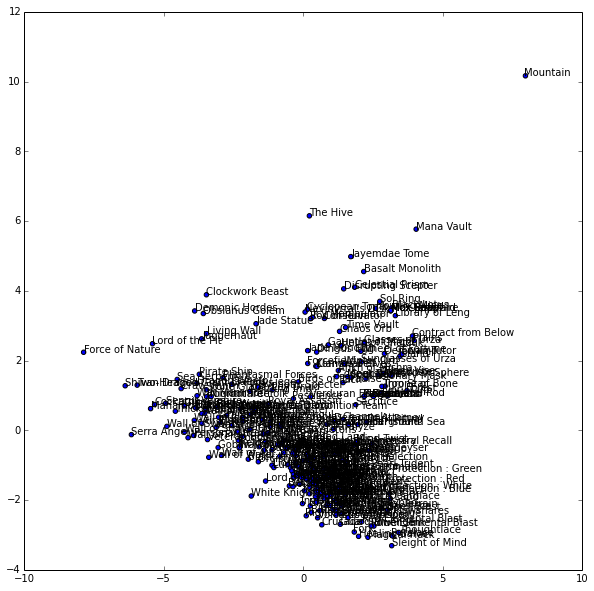

In [253]:
labels = data.index

x = [_[0] for _ in Y_pca]
y = [_[1] for _ in Y_pca]

x2 = [_[0] for _ in Y_pca if _[1] < 1 and _[1] > -2]
y2 = [_[1] for _ in Y_pca if _[1] < 1 and _[1] > -2]

fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.scatter(x, y)

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i],y[i]), fontsize = 'medium')

In [254]:
# pca output

print pca.explained_variance_ratio_

[ 0.0772052  0.053525 ]


In [255]:
# count most commonly used words in cardText

wordcounts = Counter()

for row in data['cardText']:
    for word in row:
        wordcounts[word] += 1
        
wordcounts.most_common(10)

[(u'Tap', 38),
 ('enchant creature', 26),
 (u'1', 20),
 (u'Black', 17),
 ('flying', 17),
 (u'Red', 13),
 (',', 13),
 (u'Green', 11),
 ('to your mana pool.', 11),
 (u'White', 9)]